# Last-layer Low-Rank Kalman filter (LL-LRKF)
Kalman-filter-based low-rank Bayesian last-layer method.

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import jax
import keras
import optax
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
from functools import partial
from jax.flatten_util import ravel_pytree

from rebayes_mini.methods import low_rank_filter_revised as lrkf
from rebayes_mini.methods import low_rank_last_layer as flores

In [5]:
sns.set_palette("colorblind")

In [6]:
%config InlineBackend.figure_format = "retina"

## Load dataset

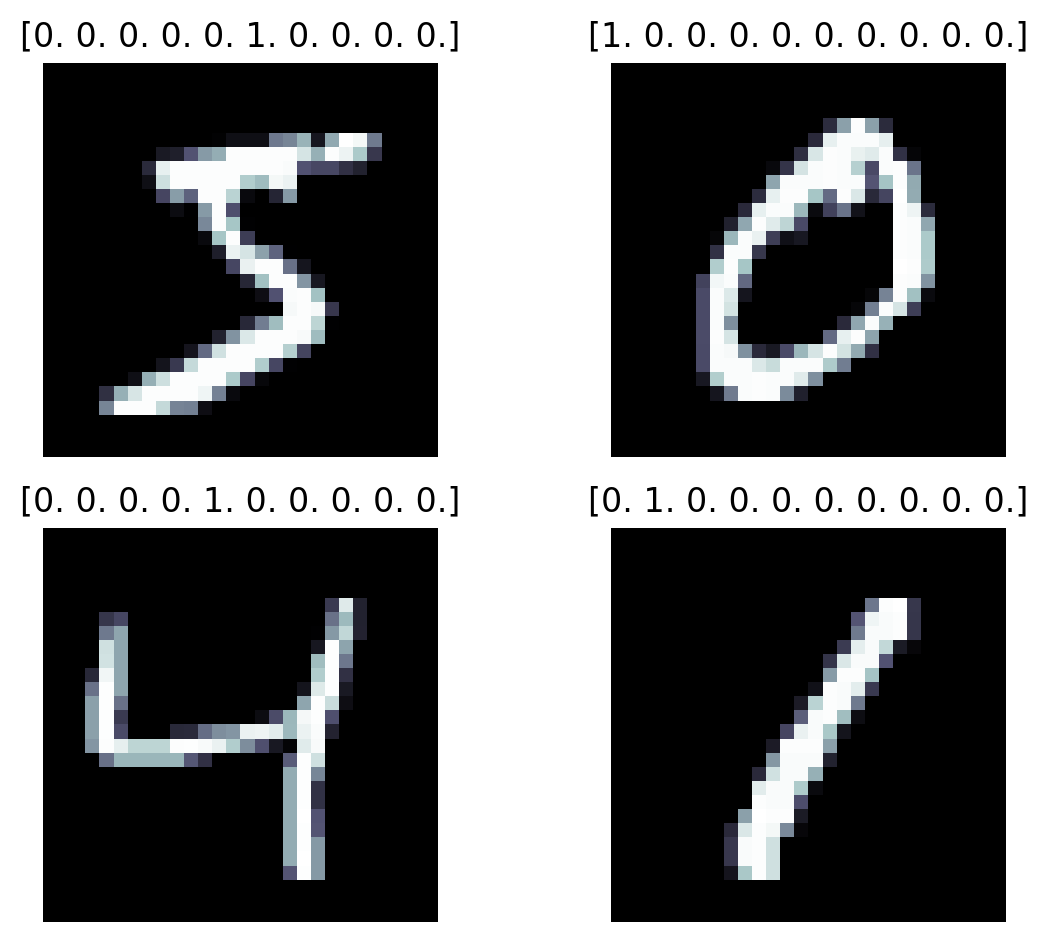

In [7]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
# X_train = einops.rearrange(X_train, "s w h -> s (w h)") / 255
# X_test = einops.rearrange(X_test, "s w h -> s (w h)") / 255
X_train = X_train[..., None] / 255
X_test = X_test[..., None] / 255
y_train = jax.nn.one_hot(y_train, 10)
X_train = jnp.array(X_train)
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.ravel()):
    ax.imshow(X_train[i], cmap="bone")
    ax.set_title(y_train[i])
    ax.axis("off")
plt.tight_layout()

## Train

In [8]:
X_eval = X_test[:5_000]
y_eval = y_test[:5_000]

In [9]:
class CNN(nn.Module):
    num_arms: int = 10

    @nn.compact
    def __call__(self, x):
        x = x if len(x.shape) > 3 else x[None, :]
        x = nn.Conv(features=6, kernel_size=(5, 5))(x)
        x = nn.elu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = nn.Conv(features=16, kernel_size=(5, 5), padding="VALID")(x)
        x = nn.elu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=120)(x)
        x = nn.elu(x)
        x = nn.Dense(features=84)(x)
        x = nn.elu(x)
        # x = nn.Dense(20, name="last_layer")(x)
        # x = nn.relu(x)
        x = nn.Dense(10, name="last_layer")(x)
        return x.squeeze()

model = CNN()

## Revised version

In [10]:
def callbackfn(bel_update, bel_pred, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat = agent.predict_fn(bel_pred, x)
    acc = y.argmax() == yhat.argmax()
    return acc

In [11]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=0.1):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [12]:
n_sims = 1
key = jax.random.PRNGKey(314)
keys = jax.random.split(key, n_sims)
model = CNN()

In [13]:
n_obs = len(X_train)

In [14]:
%%time

def run_lrkf(key, rank=50):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    params = model.init(key_init, X_train[:1])
    agent = lrkf.LowRankCovarianceFilter(
        mean_fn,
        cov_fn,
        dynamics_covariance=0.01,
        rank=rank,
    )
    bel_init = agent.init_bel(params, cov=1.0, low_rank_diag=True)
    
    cfn = partial(callbackfn, agent=agent)
    bel, hist_lrkf = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    return hist_lrkf

hist_lrkf = jax.vmap(run_lrkf)(keys)
hist_lrk = jax.tree.map(np.array, hist_lrkf)

(50, 61706)
CPU times: user 25.6 s, sys: 146 ms, total: 25.7 s
Wall time: 1min


In [15]:
df_lrkf = pd.DataFrame(hist_lrkf.T)
df_lrkf.shape

(60000, 1)

In [19]:
def plot_err_bound(df, ax, label, periods=5000, min_periods=None):
    min_periods = periods if min_periods is None else min_periods
    df.rolling(periods, min_periods=min_periods).mean().mean(axis=1).plot(label=label, ax=ax)
    # lbound = df.rolling(periods, min_periods=min_periods).mean().quantile(0.25, axis=1)
    # ubound = df.rolling(periods, min_periods=min_periods).mean().quantile(0.75, axis=1)
    # ax.fill_between(lbound.index, lbound, ubound, alpha=0.4)

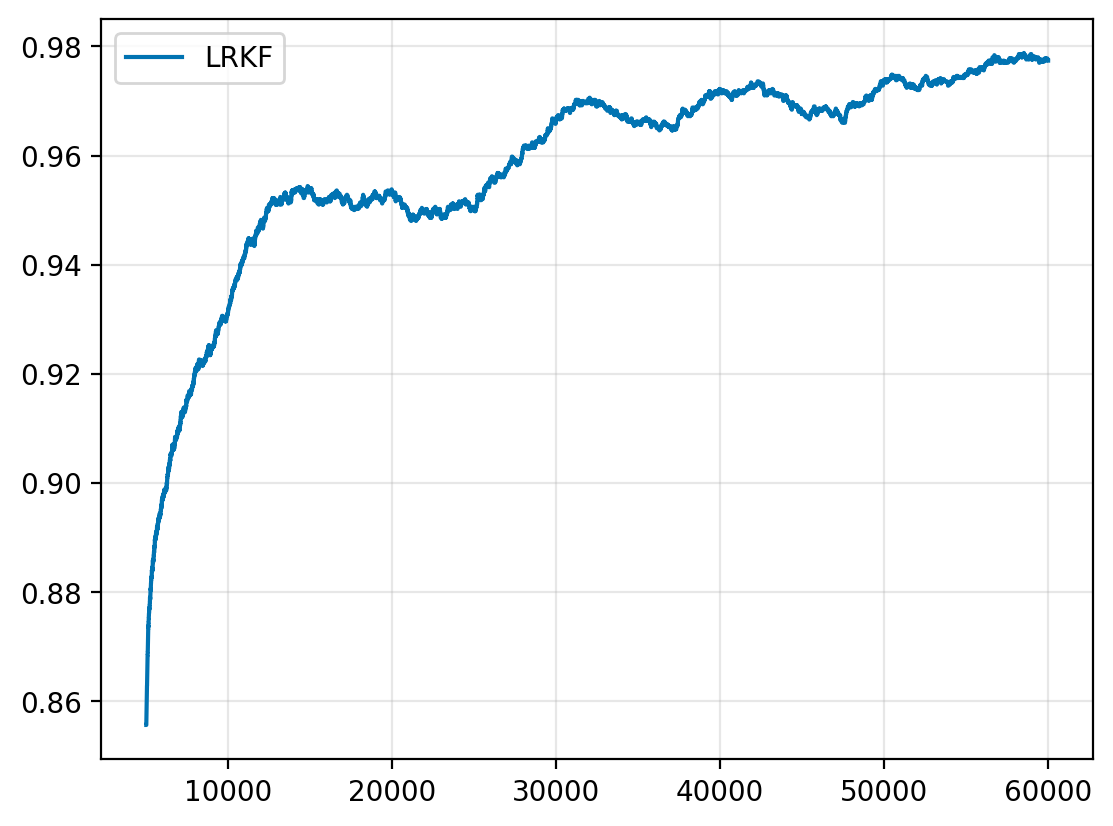

In [20]:
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plt.legend()
plt.grid(alpha=0.3)

# Last-layer Low-rank Kalman filter (LL-LRKF)

In [21]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=1e-4):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [23]:
%%time
def run_flores(key, rank=50):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    agent = flores.LowRankLastLayer(
        mean_fn, cov_fn, rank=rank, rank_last=50,
        # dynamics_hidden=1e-6, dynamics_last=1e-6,
        dynamics_hidden=0.01, dynamics_last=0.01,
    )
    params = model.init(key, X_train[:100])
    
    bel_init = agent.init_bel(params, cov_hidden=1.0, cov_last=1.0, low_rank_diag=True)
    
    cfn = partial(callbackfn, agent=agent)
    bel_flores, hist_flores = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    
    return hist_flores

hist_flores = jax.vmap(run_flores)(keys)
hist_flores = jax.tree.map(np.array, hist_flores)

CPU times: user 15.6 s, sys: 242 ms, total: 15.8 s
Wall time: 58.1 s


In [24]:
df_flores = pd.DataFrame(hist_flores.T)
df_flores.shape

(60000, 1)

CPU times: user 53.2 ms, sys: 3.85 ms, total: 57.1 ms
Wall time: 56.9 ms


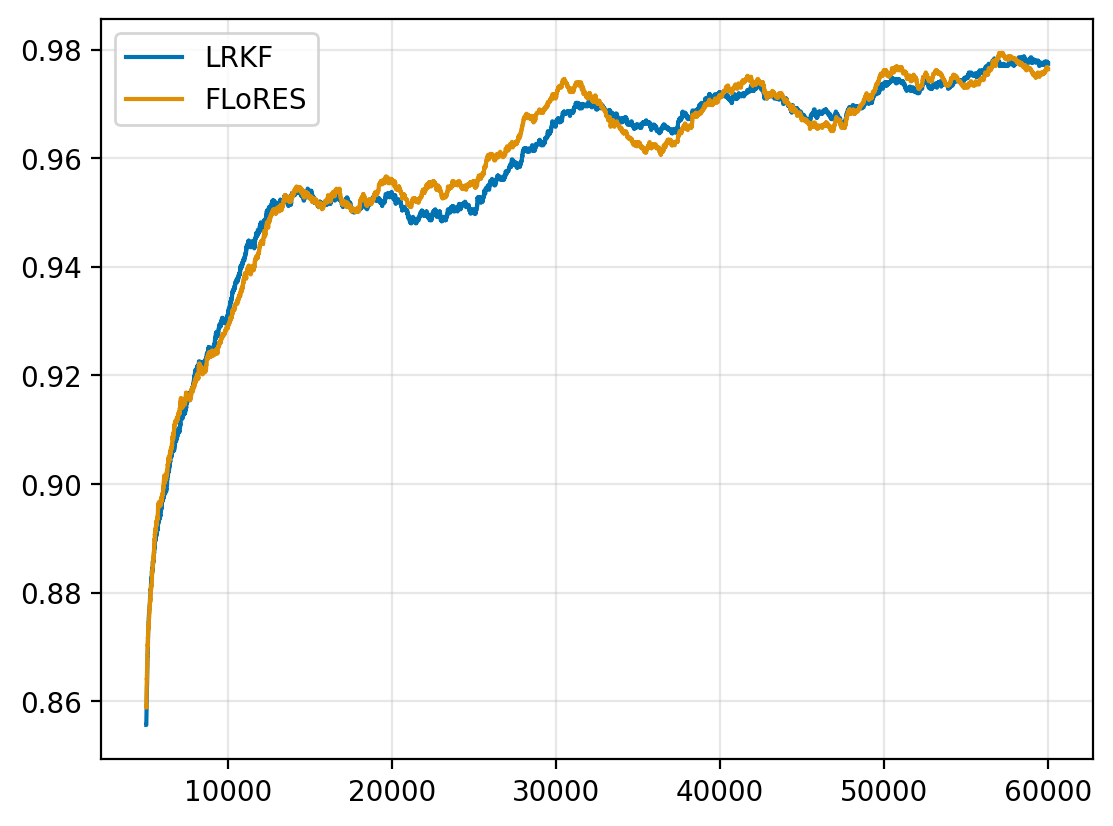

In [25]:
%%time
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_flores, ax, "FLoRES")
plt.legend()
plt.grid(alpha=0.3)

## Low-rank (precision) filter (LoFi)

In [26]:
from rebayes_mini.methods import low_rank_filter as lofi

In [27]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=0.01):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [28]:
%%time

def run_lofi(key, rank=50):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    agent = lofi.LowRankPrecisionFilter(
        mean_fn, cov_fn, rank=rank, dynamics_covariance=0.0,
    )
    params = model.init(key_init, X_train[:100])
    
    bel_init = agent.init_bel(params, cov=jnp.exp(-8))
    
    cfn = partial(callbackfn, agent=agent)
    bel, hist_lofi = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    return hist_lofi

hist_lofi = jax.vmap(run_lofi)(keys)
hist_lofi = jax.tree.map(np.array, hist_lofi)

CPU times: user 13.6 s, sys: 225 ms, total: 13.8 s
Wall time: 48.8 s


In [29]:
df_lofi = pd.DataFrame(hist_lofi.T)
df_lofi.shape

(60000, 1)

CPU times: user 73.9 ms, sys: 0 ns, total: 73.9 ms
Wall time: 73.8 ms


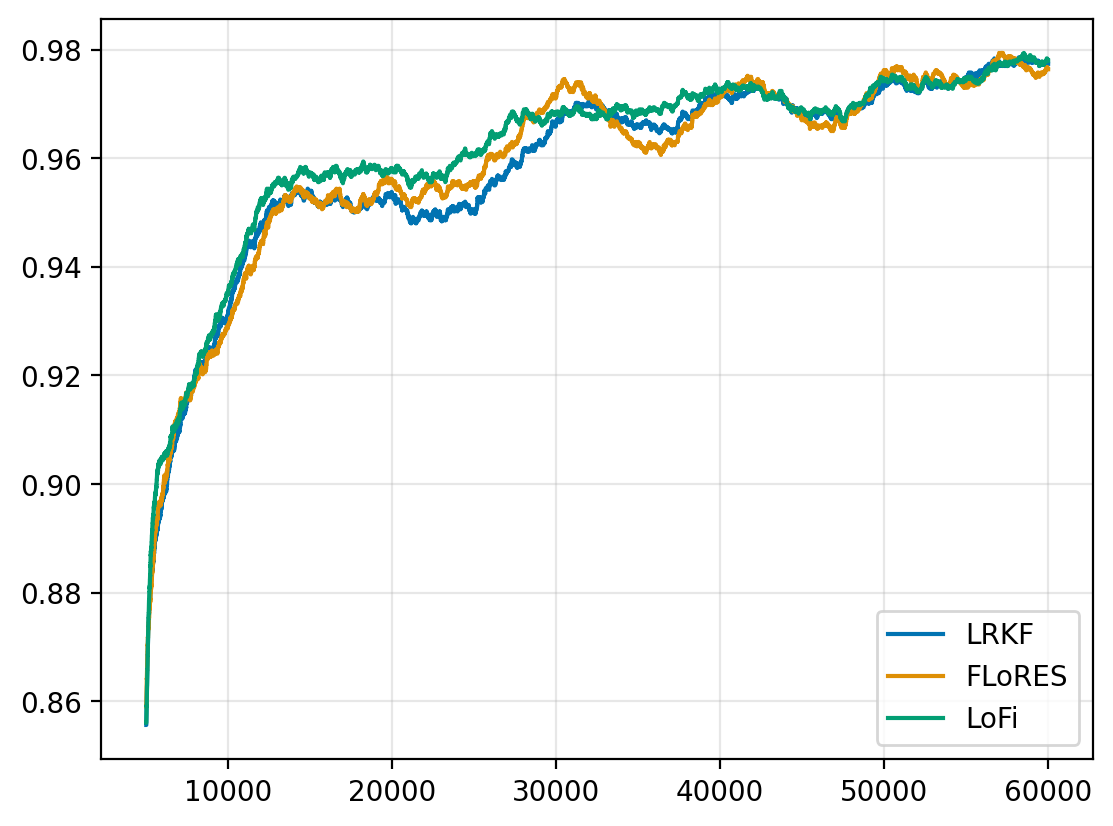

In [30]:
%%time
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_flores, ax, "FLoRES")
plot_err_bound(df_lofi, ax, "LoFi")
plt.legend()
plt.grid(alpha=0.3)

## Muon Shampoo

In [137]:
from rebayes_mini.methods import replay_sgd

In [138]:
yhat = model.apply(params, X_train[:10])

In [139]:
def lossfn(params, counter, X, y, fn):
    yhat = fn(params, X)
    loss = optax.losses.softmax_cross_entropy(yhat, y)
    return (loss * counter).sum() / counter.sum()

In [163]:
%%time

def run_muon(key):
    key_init, key_shuffle = jax.random.split(key)
    
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    params = model.init(key_init, X_train[:100])
    
    agent = replay_sgd.FifoSGD(
        model.apply,
        lossfn,
        tx=optax.contrib.muon(learning_rate=1e-3),
        buffer_size=1,
        dim_features=(28, 28, 1),
        dim_output=10
    )
    
    cfn = partial(callbackfn, agent=agent)
    bel_init = agent.init_bel(params)
    bel_muon, hist_muon = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    return hist_muon

hist_muon = jax.vmap(run_muon)(keys)
hist_muon = jax.tree.map(np.array, hist_muon)

CPU times: user 11.8 s, sys: 187 ms, total: 12 s
Wall time: 30.1 s


In [164]:
df_muon = pd.DataFrame(hist_muon.T)
df_muon.shape

(60000, 10)

CPU times: user 27.8 s, sys: 154 ms, total: 28 s
Wall time: 27.9 s


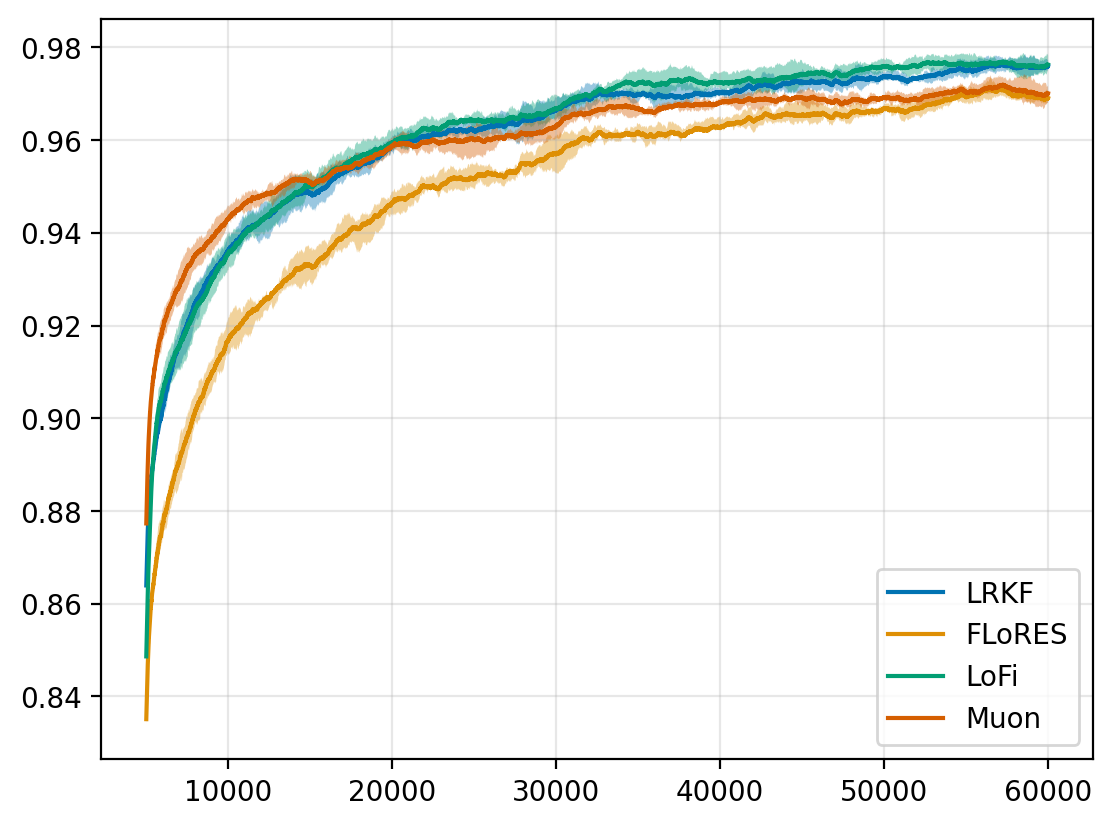

In [165]:
%%time
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_flores, ax, "FLoRES")
plot_err_bound(df_lofi, ax, "LoFi")
plot_err_bound(df_muon, ax, "Muon")
plt.legend()
plt.grid(alpha=0.3)

## Adamw

In [152]:
%%time
def run_adamw(key):
    key_init, key_shuffle = jax.random.split(key)
    
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    params = model.init(key_init, X_train[:100])
    
    agent = replay_sgd.FifoSGD(
        model.apply,
        lossfn,
        tx=optax.adamw(learning_rate=1e-4),
        buffer_size=5,
        dim_features=(28, 28, 1),
        dim_output=10
    )
    
    cfn = partial(callbackfn, agent=agent)
    bel_init = agent.init_bel(params)
    bel, hist = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    return hist
    
hist_adamw = jax.vmap(run_adamw)(keys)
hist_adamw = jax.tree.map(np.array, hist_adamw)

CPU times: user 16.7 s, sys: 298 ms, total: 17 s
Wall time: 55 s


In [153]:
df_adamw = pd.DataFrame(hist_adamw.T)
df_adamw.shape

(60000, 10)

CPU times: user 35.4 s, sys: 186 ms, total: 35.6 s
Wall time: 35.5 s


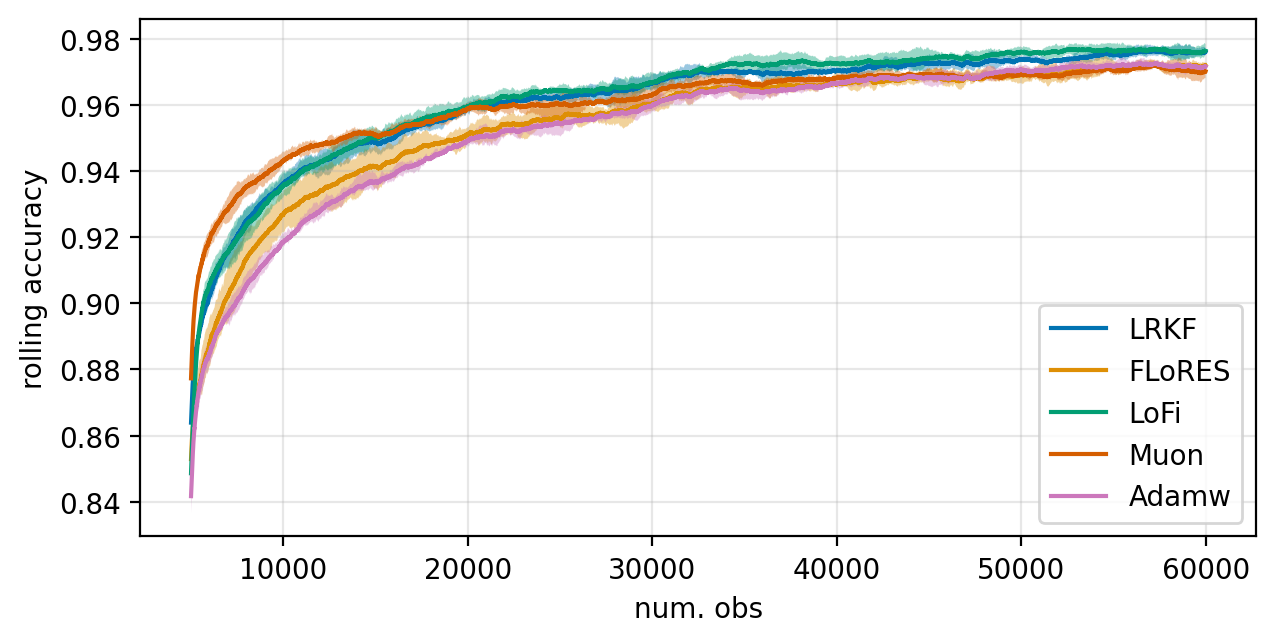

In [182]:
%%time
fig, ax = plt.subplots(figsize=(7.2, 4.2 * 0.8))
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_flores, ax, "FLoRES")
plot_err_bound(df_lofi, ax, "LoFi")
plot_err_bound(df_muon, ax, "Muon")
plot_err_bound(df_adamw, ax, "Adamw")
plt.legend()
plt.ylabel("rolling accuracy")
plt.xlabel("num. obs")
plt.grid(alpha=0.3)
plt.savefig("../figures/mnist-online-classification.png", dpi=300, bbox_inches="tight")

# Plot results

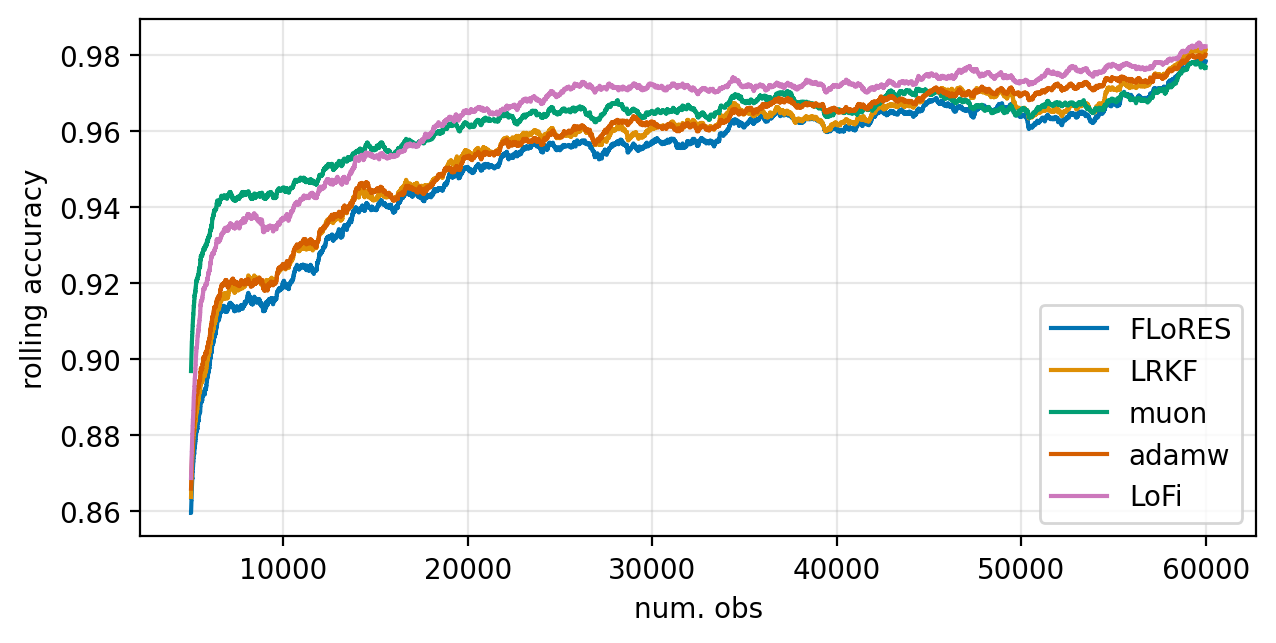

In [58]:
fig, ax = plt.subplots(figsize=(7.2, 4.2 * 0.8))


min_periods = 5000
pd.Series(hist_flores).rolling(5000, min_periods=min_periods).mean().plot(label="FLoRES")
pd.Series(hist_lrkf).rolling(5000, min_periods=min_periods).mean().plot(label="LRKF")
pd.Series(hist_muon).rolling(5000, min_periods=min_periods).mean().plot(label="muon")
pd.Series(hist_adamw).rolling(5000, min_periods=min_periods).mean().plot(label="adamw")
pd.Series(hist_lofi).rolling(5000, min_periods=min_periods).mean().plot(label="LoFi")
plt.grid(alpha=0.3)
plt.ylabel("rolling accuracy")
plt.xlabel("num. obs")
plt.legend()

## Multiple ranks

With constant full-rank inflation

In [183]:
key = jax.random.PRNGKey(3141)

In [204]:
%%time
ranks = [0, 1, 2, 5, 10, 20, 30, 50, 70, 100]
hist_all = {}
times_all = {}
params = model.init(key, X_train[:100])
for rank in ranks:
    print(rank, end="\r")

    agent = lrkf.LowRankCovarianceFilter(
        mean_fn,
        cov_fn,
        dynamics_covariance=0.01,
        rank=rank,
    )
    bel_init = agent.init_bel(params, cov=1.0, low_rank_diag=True)


    time_init = time()
    cfn = partial(callbackfn, agent=agent)
    bel, hist_lrkf = agent.scan(bel_init, y_train[:20_000], X_train[:20_000], cfn)
    hist_lrkf = np.array(hist_lrkf) * 1.0
    times_all[rank] = time() - time_init
    hist_all[rank] = hist_lrkf

hist_all = pd.DataFrame(hist_all)

CPU times: user 1min 46s, sys: 2.1 s, total: 1min 48s
Wall time: 2min 14s


In [205]:
times_all

{0: 10.78065299987793,
 1: 12.843039512634277,
 2: 12.167240142822266,
 5: 12.281671285629272,
 10: 12.493818759918213,
 20: 12.994854211807251,
 30: 13.339035511016846,
 50: 14.3035249710083,
 70: 15.146733283996582,
 100: 18.53090524673462}

In [206]:
colors = plt.cm.viridis(jnp.linspace(0, 1, len(ranks)))

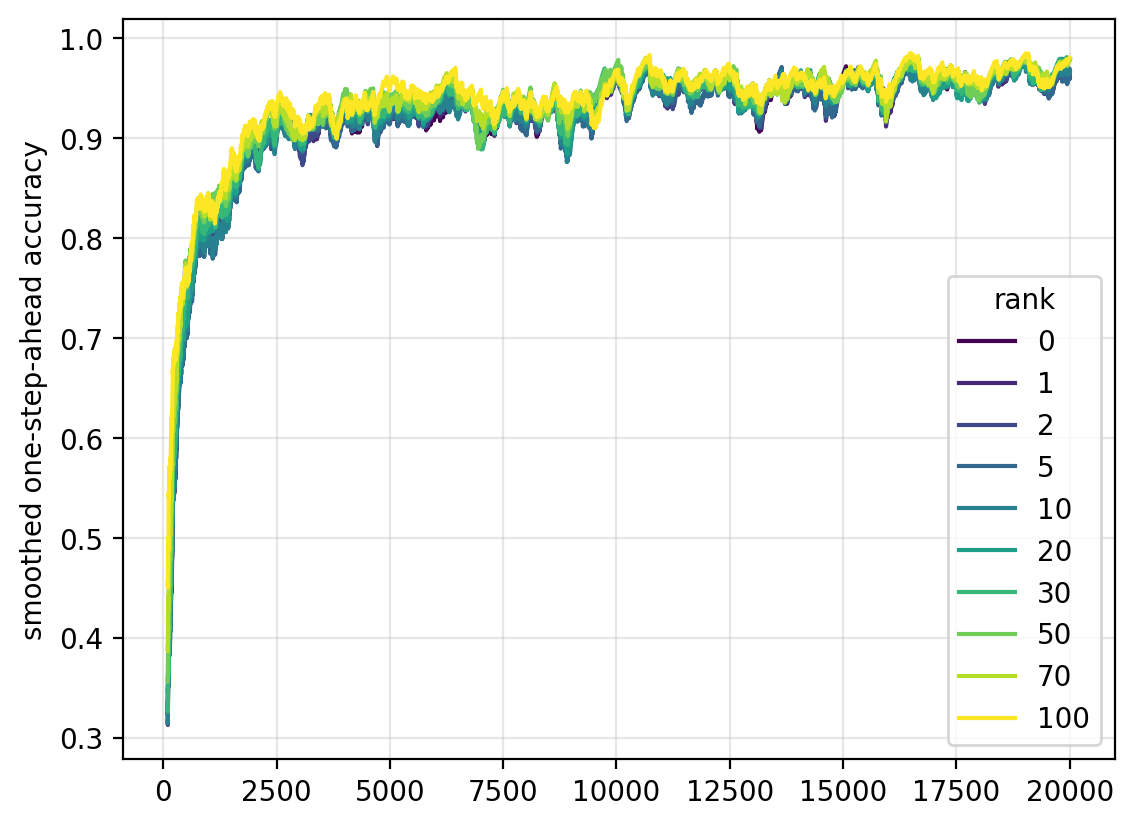

In [207]:
hist_all.ewm(min_periods=100, span=500).mean().plot(color=colors)
plt.ylabel("smoothed one-step-ahead accuracy")
plt.legend(title="rank")
plt.grid(alpha=0.3)

## Time / performance of LoFi / LRKF

In [31]:
key = jax.random.PRNGKey(314)

In [32]:
from tqdm import tqdm

In [54]:
# ranks = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ranks = [1, 5, 10, 50, 100]


# result = []
for rank in tqdm(ranks):
    time_init = time()
    # hist = run_lrkf(key, rank)
    # hist = jax.tree.map(np.array, hist)
    # time_end = time()
    # running_time = time_end - time_init
    # result.append({
    #     "method": "LRKF",
    #     "running_time": running_time,
    #     "accuracy": hist[5000:],
    #     "rank": rank,
    # })

    time_init = time()
    hist = run_lofi(key, rank)
    hist = jax.tree.map(np.array, hist)
    time_end = time()
    running_time = time_end - time_init
    result.append({
        "method": "LoFi-deg",
        "running_time": running_time,
        "accuracy": hist[5000:],
        "rank": rank,
    })


    # time_init = time()
    # hist = run_flores(key, rank)
    # hist = jax.tree.map(np.array, hist)
    # time_end = time()
    # running_time = time_end - time_init
    # result.append({
    #     "method": "HiLoBayes",
    #     "running_time": running_time,
    #     "accuracy": hist[5000:],
    #     "rank": rank,
    # })

  0%|                                                                                                                                           | 0/5 [00:00<?, ?it/s]

Testing time performance
Testing time performance for Gt


 20%|██████████████████████████▏                                                                                                        | 1/5 [00:16<01:04, 16.12s/it]

Testing time performance
Testing time performance for Gt


 40%|████████████████████████████████████████████████████▍                                                                              | 2/5 [00:32<00:48, 16.09s/it]

Testing time performance
Testing time performance for Gt


 60%|██████████████████████████████████████████████████████████████████████████████▌                                                    | 3/5 [00:48<00:32, 16.34s/it]

Testing time performance
Testing time performance for Gt


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 4/5 [01:08<00:17, 17.69s/it]

Testing time performance
Testing time performance for Gt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.98s/it]


In [67]:
df_result = pd.DataFrame(result)

df_result["accuracy"] = df_result["accuracy"].apply(lambda x: x.mean())

df_result = df_result.query("method != 'LoFi-deg'")

Text(0, 0.5, 'running time')

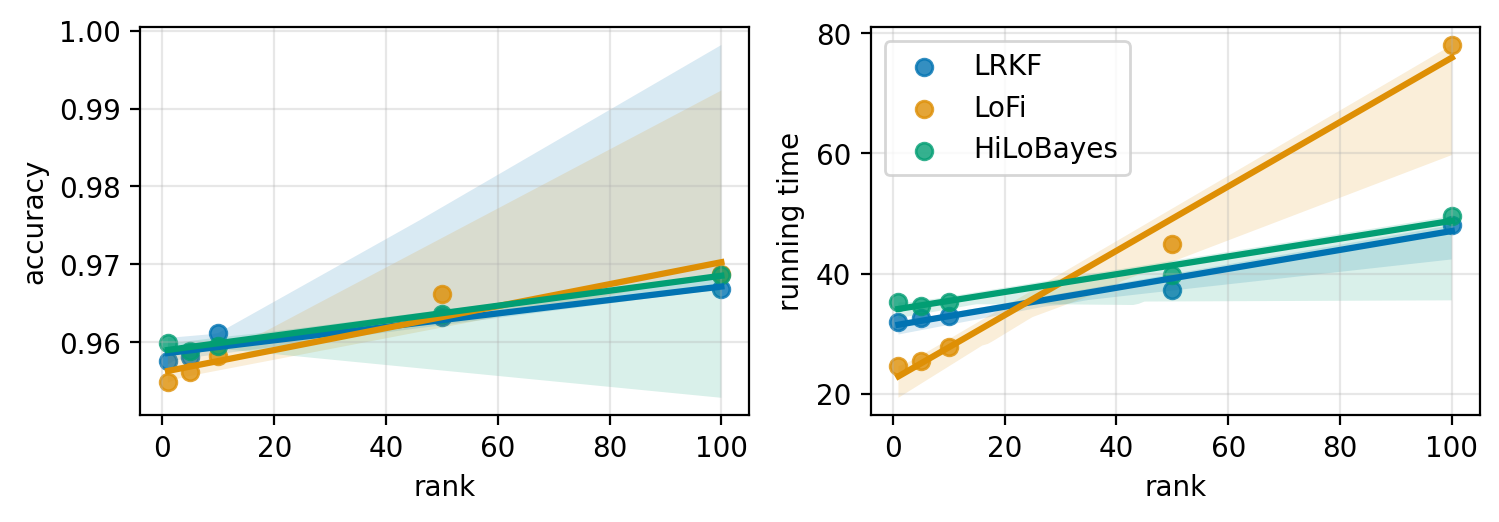

In [68]:
methods = df_result["method"].unique()
fig, axs = plt.subplots(1, 2, figsize=(7.2 * 1.2, 4.2 * 0.6))

plt.sca(axs[0])
for method in methods:
    sns.regplot(x="rank", y="accuracy", data=df_result.query("method == @method"), ax=axs[0], label=method)
axs[0].grid(alpha=0.3)
# plt.legend()

plt.sca(axs[1])
for method in methods:
    sns.regplot(x="rank", y="running_time", data=df_result.query("method == @method"), ax=axs[1], label=method)
axs[1].grid(alpha=0.3)
axs[1].legend()
axs[1].set_ylabel("running time")

# plt.savefig("../figures/mnist-online-classification-rank-comparison.png", dpi=300, bbox_inches="tight")

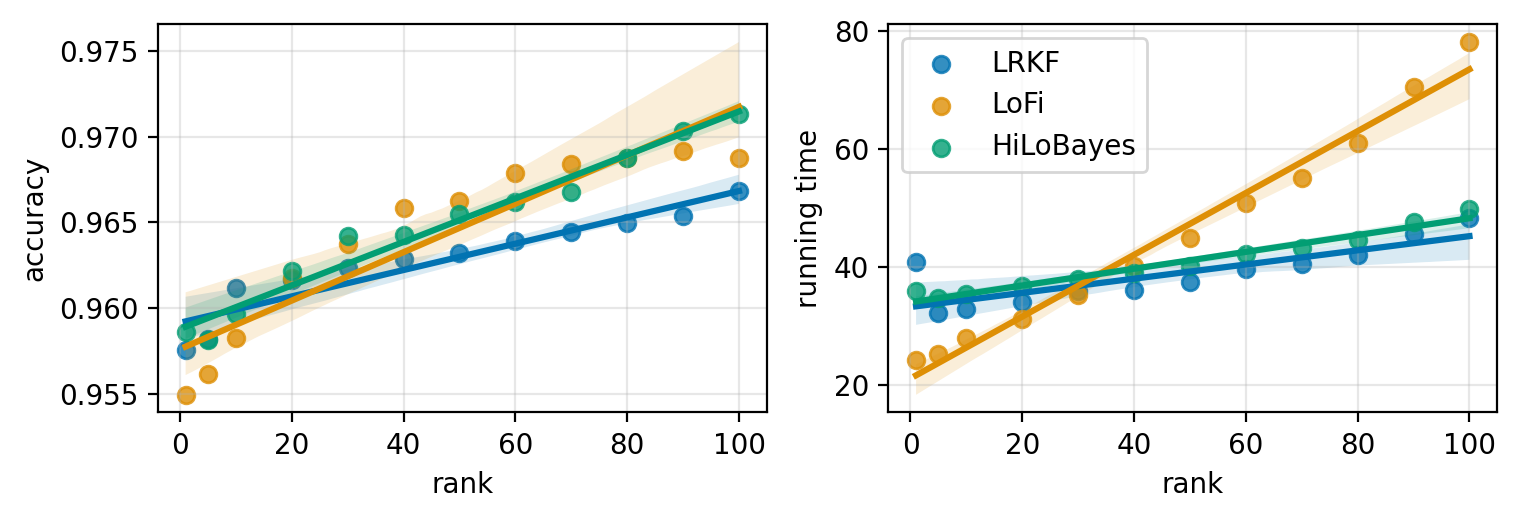

In [70]:
methods = df_result["method"].unique()
fig, axs = plt.subplots(1, 2, figsize=(7.2 * 1.2, 4.2 * 0.6))

plt.sca(axs[0])
for method in methods:
    sns.regplot(x="rank", y="accuracy", data=df_result.query("method == @method"), ax=axs[0], label=method)
axs[0].grid(alpha=0.3)
# plt.legend()

plt.sca(axs[1])
for method in methods:
    sns.regplot(x="rank", y="running_time", data=df_result.query("method == @method"), ax=axs[1], label=method)
axs[1].grid(alpha=0.3)
axs[1].legend()
axs[1].set_ylabel("running time")
# plt.savefig("../figures/mnist-online-classification-rank-comparison.png", dpi=300, bbox_inches="tight")